## Preprocessing and Fetching

In [4]:
import pandas as pd

#Load files
content = pd.read_csv('Content.csv')
cities = pd.read_csv('Cities.csv')
date = pd.read_csv('Date.csv')
source = pd.read_csv('Traffic source.csv')

In [5]:
#Remove first row (totals)
content = content.iloc[1:]
cities = cities.iloc[1:]
date = date.iloc[1:]
source = source.iloc[1:]

In [6]:
# Datetime
content['Video publish time'] = pd.to_datetime(content['Video publish time'])
content['Duration'] = pd.to_timedelta(content['Duration'], unit='s')
content['Watch time (hours)'] = pd.to_timedelta(content['Watch time (hours)'], unit='h')
content['Average view duration'] = pd.to_timedelta(content['Average view duration'])
content['Impressions click-through rate (%)'] = content['Impressions click-through rate (%)'] / 100
content.rename(columns={'Impressions click-through rate (%)': 'Impressions CTR'}, inplace=True)

In [7]:
date['Date'] = pd.to_datetime(date['Date'])
date['Watch time (hours)'] = pd.to_timedelta(date['Watch time (hours)'], unit='h')
date['Average view duration'] = pd.to_timedelta(date['Average view duration'])

cities['Watch time (hours)'] = pd.to_timedelta(cities['Watch time (hours)'], unit='h')
cities['Average view duration'] = pd.to_timedelta(cities['Average view duration'])

source['Watch time (hours)'] = pd.to_timedelta(source['Watch time (hours)'], unit='h')
source['Average view duration'] = pd.to_timedelta(source['Average view duration'])

In [8]:
print(content.head())

       Content                                        Video title  \
1  9rU6Jf1EpLg  I LOVE the new Jinx design #shorts #arcane #le...   
2  RhvaJIXedtY  Season 2 Vi is 🥵🥵🥵🥵 #shorts  #arcane #leagueof...   
3  B0MKg88uE1g  Maddie makes me 😡😡🤬😠 #arcane #leagueoflegends ...   
4  Mk0-nA1Vad8  The most UNDERRATED enforcer #arcane #leagueof...   
5  f40T4AbyJiI  Arcane's time travel explained! #arcane #leagu...   

  Video publish time        Duration      Views          Watch time (hours)  \
1         2024-09-09 0 days 00:00:31  1348535.0 419 days 22:19:58.439999996   
2         2024-09-22 0 days 00:00:32   735917.0    216 days 00:57:31.320000   
3         2024-11-27 0 days 00:00:23   638341.0    189 days 13:29:33.360000   
4         2024-11-28 0 days 00:00:29   587002.0    200 days 23:41:38.400000   
5         2024-11-25 0 days 00:00:26   546862.0    216 days 13:29:51.720000   

   Subscribers Average view duration  Impressions  Impressions CTR  
1        604.0       0 days 00:00:26     

# Statistical Testing

**Anova Test on Importance of Publishing Date and Runtime**

In [9]:
# Convert time to datetime seconds
content['Duration_sec'] = content['Duration'].dt.total_seconds()

# Define bins for video length
bins_runtime = [0, 30, 60, float('inf')]
labels_runtime = ['Short', 'Medium', 'Long']
content['Runtime_Category'] = pd.cut(content['Duration_sec'], bins=bins_runtime, labels=labels_runtime)

# Categorize publishing day according to days of the week (0 = Monday, 6 = Sunday)
content['Publish_Day'] = content['Video publish time'].dt.day_name()

In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Drop rows with missing values
anova_data = content.dropna(subset=['Views', 'Runtime_Category', 'Publish_Day'])

# Run two-way anova on runtime and publish day
model = ols('Views ~ C(Runtime_Category) + C(Publish_Day) + C(Runtime_Category):C(Publish_Day)', data=anova_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                          sum_sq     df          F  \
C(Runtime_Category)                 6.139887e+11    2.0  21.666612   
C(Publish_Day)                      1.162959e+11    6.0   1.367962   
C(Runtime_Category):C(Publish_Day)  3.411711e+11   12.0   2.006558   
Residual                            2.989660e+12  211.0        NaN   

                                          PR(>F)  
C(Runtime_Category)                 2.765491e-09  
C(Publish_Day)                      2.288752e-01  
C(Runtime_Category):C(Publish_Day)  2.502329e-02  
Residual                                     NaN  


- According to their respective p-values, runtime had a statistically significant affect on view-count, whereas the publishing date did not

C:\Users\William\AppData\Local\Temp\ipykernel_584492\2105572615.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_views = anova_data.groupby(['Runtime_Category', 'Publish_Day'])['Views'].mean().reset_index()


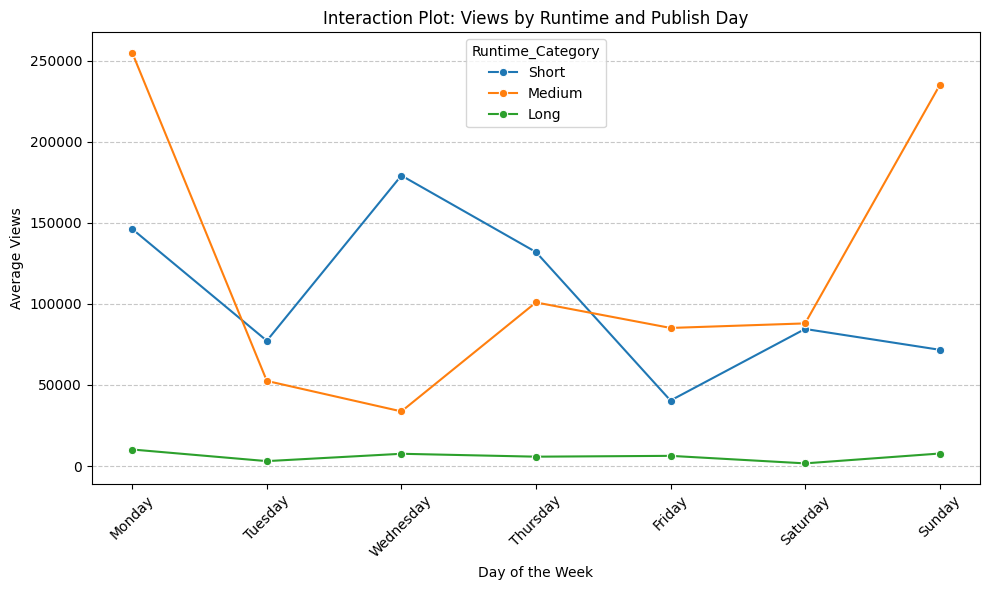

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean views grouped by Runtime_Category and Publish_Day
mean_views = anova_data.groupby(['Runtime_Category', 'Publish_Day'])['Views'].mean().reset_index()

# Sort days of the week for proper ordering
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_views['Publish_Day'] = pd.Categorical(mean_views['Publish_Day'], categories=ordered_days, ordered=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_views, x='Publish_Day', y='Views', hue='Runtime_Category', marker='o')
plt.title('Interaction Plot: Views by Runtime and Publish Day')
plt.ylabel('Average Views')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Z-Test on Importance of Runtime by Category**

In [12]:
from scipy.stats import zscore

# Drop missing values
normalized_data = content.dropna(subset=['Views', 'Runtime_Category'])

# Normalize viewcounts with z-score
normalized_data['Views_Z'] = zscore(normalized_data['Views'])

# Group by runtime category and calculate average z-scores
avg_zscores = normalized_data.groupby('Runtime_Category')['Views_Z'].mean().sort_values(ascending=False)

print("Average Z-Score of Views per Runtime Category:")
print(avg_zscores)

Average Z-Score of Views per Runtime Category:
Runtime_Category
Medium    0.525609
Short     0.437280
Long     -0.344424
Name: Views_Z, dtype: float64


C:\Users\William\AppData\Local\Temp\ipykernel_584492\1329682029.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_data['Views_Z'] = zscore(normalized_data['Views'])
C:\Users\William\AppData\Local\Temp\ipykernel_584492\1329682029.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_zscores = normalized_data.groupby('Runtime_Category')['Views_Z'].mean().sort_values(ascending=False)


- Further analysis of runtime has shown that that a medium runtime of 30-60 seconds had the most postiive affect on view-count

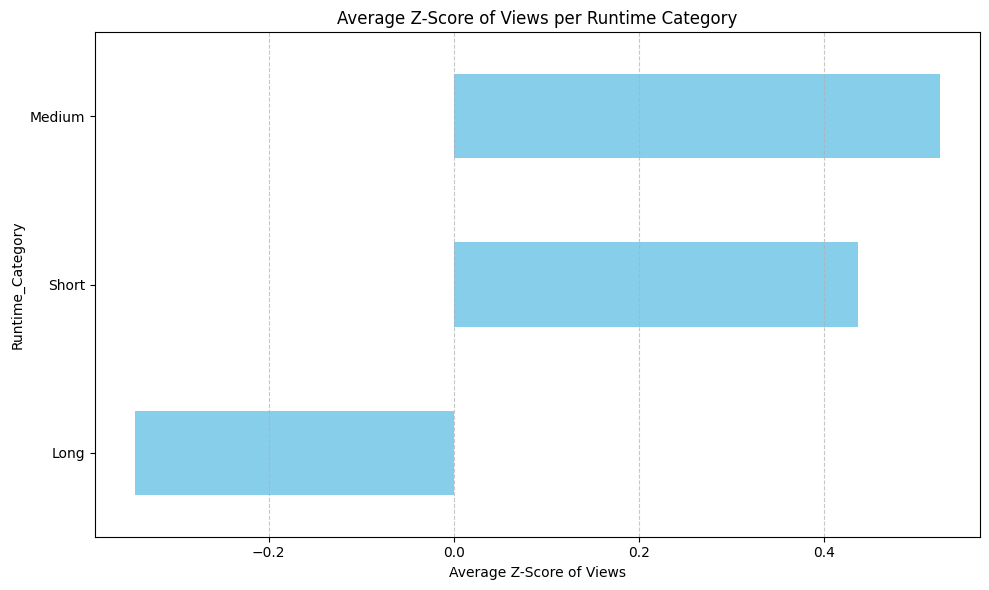

In [13]:
# Plotting the average Z-scores
plt.figure(figsize=(10, 6))
avg_zscores.sort_values().plot(kind='barh', color='skyblue')

plt.xlabel('Average Z-Score of Views')
plt.title('Average Z-Score of Views per Runtime Category')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Tests on Correlation between City and Views**

In [14]:
cities_clean = cities.dropna(subset=['City name', 'Views', 'Average view duration']).copy()
cities_clean['Views'] = pd.to_numeric(cities_clean['Views'], errors='coerce')

# Normalize with z-scores
cities_clean['Views_Z'] = zscore(cities_clean['Views'])

# Bin into 4 quartile categories based on z-score ranks
cities_clean['Views_Quartile'] = pd.qcut(cities_clean['Views_Z'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])  # Q1 = lowest views

In [15]:
from scipy.stats import chi2_contingency

# Contingency table for Chi^2 test
views_table = pd.crosstab(cities_clean['City name'], cities_clean['Views_Quartile'])

# Chi-square test
chi2_v, p_v, dof_v, _ = chi2_contingency(views_table)
print(f"Views Quartile vs City: χ² = {chi2_v:.4f}, p = {p_v:.8g}")

Views Quartile vs City: χ² = 1500.0000, p = 0.47330172


- The resulting p value shows that city has no statistically significant affect on view-count, and we don't necessarily have to appeal to any geographic location in particular

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px
import time

# Convert Views column to numeric
cities_clean['Views'] = pd.to_numeric(cities_clean['Views'], errors='coerce')
cities_clean['Cleaned City Name'] = cities_clean['City name'].str.extract(r'([a-zA-Z\s]+)')[0]

# Load the city coordinates data (adjust the CSV file path)
city_coords = pd.read_csv('worldcities.csv')

# Merge the YouTube analytics data with the city coordinates data
# Ensure that city names match in both datasets (using 'Cleaned City Name' for merge)
merged_data = pd.merge(cities_clean, city_coords[['city_ascii', 'lat', 'lng']], 
                       left_on='Cleaned City Name', right_on='city_ascii', how='left')

# Drop rows where coordinates are not found
merged_data = merged_data.dropna(subset=['lat', 'lng'])

# Plot with Plotly
fig = px.scatter_geo(
    merged_data,
    lat="lat",
    lon="lng",
    size="Views",
    color="Views",
    hover_name="City name",
    size_max=10,  # Set to a smaller value for smaller bubbles
    projection="natural earth",
    title="Heatmap of Views by City (Bubble Size = Views)",
    color_continuous_scale="YlOrRd"
)

# Adjust layout for better visualization
fig.update_layout(geo=dict(showland=True, landcolor="lightgray"))
fig.show()


**Exploring the effects of hashtags**

In [23]:
import re
content['Hashtags_List'] = content['Video title'].str.findall(r'#\w+')

In [24]:
# Extract video hashtags
content['Hashtags_List'] = content['Video title'].str.findall(r'#\w+')

# Explode to get one row for each hashtag
hashtag_df = content.explode('Hashtags_List').dropna(subset=['Hashtags_List', 'Views'])

# Remove invalid entries
hashtag_df['Views'] = pd.to_numeric(hashtag_df['Views'], errors='coerce')

In [25]:
# Count appearances and average views
hashtag_stats = hashtag_df.groupby('Hashtags_List').agg(
    count=('Views', 'count'),
    avg_views=('Views', 'mean'),
    std_views=('Views', 'std')
)

In [27]:
import numpy as np
# Normalize data to account for outliers
hashtag_stats['normalized_score'] = hashtag_stats['avg_views'] / np.log1p(hashtag_stats['count'])

In [28]:
# Sort by normalized impact
top_tags = hashtag_stats.sort_values('normalized_score', ascending=False)
print(top_tags.head(10))

                  count      avg_views      std_views  normalized_score
Hashtags_List                                                          
#leagueoflegends     57  142112.421053  230355.702197      34999.240399
#shorts              74  140910.905405  205691.791390      32637.242234
#arctober            28   88179.678571  100329.859598      26187.089886
#arcane              96  118157.343750  188802.478099      25828.373487
#arcanefics           2   10195.000000    5730.393355       9279.888915
#riotgames            2   10195.000000    5730.393355       9279.888915


In [29]:
# Normalize data to account for outliers
hashtag_stats['normalized_score'] = hashtag_stats['avg_views'] / np.log1p(hashtag_stats['count'])

# Sort by normalized impact
top_tags = hashtag_stats.sort_values('normalized_score', ascending=False)

# Visualizing the normalized impact of top hashtags
fig1 = px.bar(
    top_tags.head(10),  # Show top 10 hashtags
    x=top_tags.head(10).index,
    y='normalized_score',
    title="Top 10 Hashtags by Normalized Impact (Avg Views / Log(Hashtag Frequency))",
    labels={'normalized_score': 'Normalized Impact', 'index': 'Hashtags'},
    color='normalized_score',
    color_continuous_scale='YlOrRd'
)

fig1.update_layout(xaxis_tickangle=-45)
fig1.show()

# Bubble chart: Relationship between hashtag frequency, avg views, and normalized score
fig2 = px.scatter(
    top_tags.head(10),
    x='count',  # Hashtag frequency
    y='avg_views',  # Average views per hashtag
    size='normalized_score',  # Bubble size based on normalized score
    color='normalized_score',  # Color based on normalized score
    hover_name=top_tags.head(10).index,
    title="Hashtag Frequency vs Average Views with Normalized Impact",
    labels={'count': 'Hashtag Frequency', 'avg_views': 'Average Views'},
    color_continuous_scale='Viridis'
)

fig2.update_layout(showlegend=False)
fig2.show()

- Even after normalizaiton, the most affective hashtag at garnering views was #leagueoflegends
- Shorts should thereby have this hashtag by default whenever possible

## Machine Learning Model

In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [31]:
df = content.copy()

# Drop na or invalid entries
df = df[pd.to_numeric(df['Views'], errors='coerce').notna()].copy()
df['Views'] = df['Views'].astype(float)
views_z = zscore(df['Views'])

In [32]:
view_level = pd.qcut(
    df['Views'].astype(float), 
    q=3, 
    labels=['Low', 'Medium', 'High']
)


In [33]:
df.columns

Index(['Content', 'Video title', 'Video publish time', 'Duration', 'Views',
       'Watch time (hours)', 'Subscribers', 'Average view duration',
       'Impressions', 'Impressions CTR', 'Duration_sec', 'Runtime_Category',
       'Publish_Day', 'Hashtags_List'],
      dtype='object')

In [34]:
# Set up random forest model
model_df = pd.DataFrame({
    'Duration_sec': df['Duration_sec'],
    'Watchtime': df['Watch time (hours)'].dt.total_seconds() / 3600,
    'Impressions': df['Impressions CTR'],
    'view_level': view_level
})


model_df.dropna(inplace=True)

In [35]:
# Set independent and dependent variables
X = model_df[['Duration_sec', 'Watchtime', 'Impressions']]
y = model_df['view_level']

In [36]:
# Set train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [37]:
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [38]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       1.00      0.92      0.96        12
         Low       0.73      1.00      0.85        11
      Medium       0.90      0.69      0.78        13

    accuracy                           0.86        36
   macro avg       0.88      0.87      0.86        36
weighted avg       0.88      0.86      0.86        36



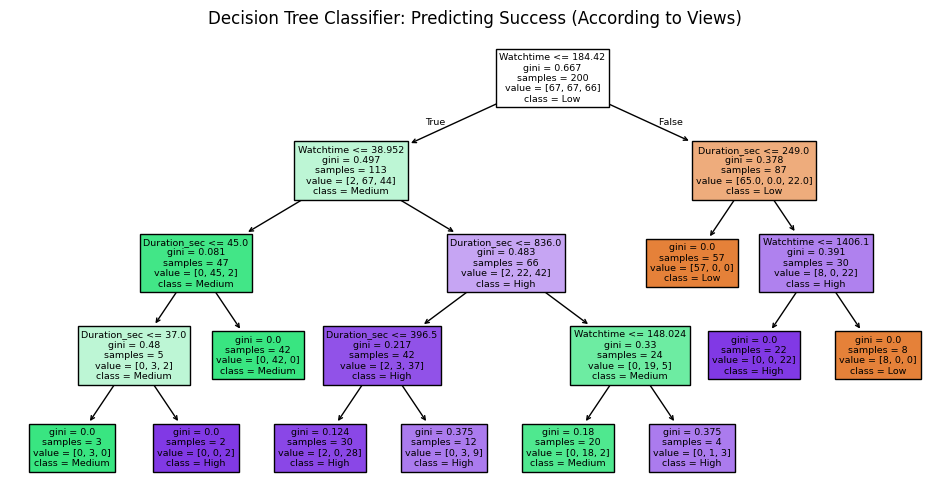

In [39]:
# Plot generated tree
plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=X.columns, class_names=['Low', 'Medium', 'High'], filled=True)
plt.title("Decision Tree Classifier: Predicting Success (According to Views)")
plt.show()